In [2]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas
from rasterio.mask import mask
import pandas as pd
import numpy as np
import json
import matplotlib.patches as mpatches
import matplotlib.colors
from scipy.signal import medfilt2d


#Other packages from Wildfires lecture that may be important
##import pyproj
##import rasterstats

## Question 1:

"You will not be able to clip a raster to a vector file using the geopandas.clip  function. You instead have to use the rasterio.mask function. Look in the US Wildfires lecture for an example." 
-Prof

In [3]:
state_file = "Homework_2/us_states.json"

country = geopandas.read_file(state_file)

In [4]:
country.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


In [5]:
country.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

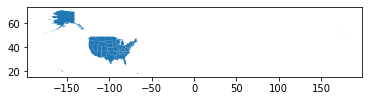

In [6]:
country.plot()

<AxesSubplot:>

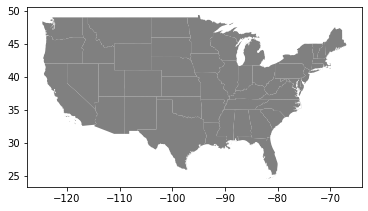

In [7]:
country = country[~country['NAME'].isin(["Alaska","Hawaii","Puerto Rico"])]

country.plot(color="Grey")

<AxesSubplot:>

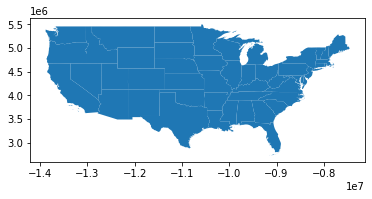

In [8]:
#Could need to reproject if user error (see wildfires) 
country_proj = country.to_crs(epsg=4087) # WGS 84 Equidistant Cylndrical
country_proj.plot()

In [9]:
raster_file16 = "Homework_2/CDL_2016_clip.tif"

raster16 = rasterio.open(raster_file16)

In [10]:
raster16.crs==country_proj.crs

False

In [11]:
type(raster16.read()),raster16.read().shape

(numpy.ndarray, (1, 22306, 34385))

In [12]:
raster16.transform

Affine(30.0, 0.0, 337545.0,
       0.0, -30.0, 2223945.0)

In [13]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [17]:
src_file16 = raster_file16
dst_file16 = 'ppt_reproj.tif'
dst_crs16 = rasterio.crs.CRS.from_dict({'init': 'EPSG:4087'})

In [20]:
with rasterio.open(src_file16) as src: 
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs16, src.width, src.height, *src.bounds) 
    kwargs = src.meta.copy() 
    kwargs.update({
        'crs': dst_crs16,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open(dst_file16, 'w', **kwargs) as dst: 
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs16,
                resampling=Resampling.nearest)

In [21]:
raster16 = rasterio.open("./ppt_reproj.tif")

raster16.crs

CRS.from_epsg(4087)

In [22]:
ppt16 = raster16.read(1)
ppt16

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

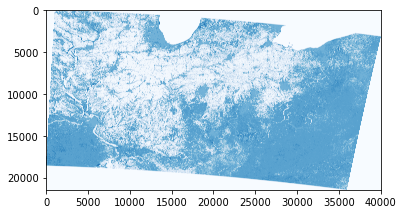

In [34]:
plt.imshow(ppt16,cmap="Blues")

In [24]:
json.loads(country_proj[country_proj.NAME=="Illinois"]['geometry'].to_json())['features'][0]['geometry']

{'type': 'Polygon',
 'coordinates': [[[-9948181.065135902, 4731108.860254603],
   [-9947683.467012053, 4731079.694548016],
   [-9939817.075195147, 4730950.675258187],
   [-9935349.04479318, 4730855.0518155955],
   [-9934927.477881545, 4730870.191266344],
   [-9932846.582640145, 4730860.951748608],
   [-9932622.941783143, 4730850.9329944365],
   [-9925994.75666233, 4730772.898031389],
   [-9925791.821230613, 4730783.028105051],
   [-9921361.973413985, 4730739.613503642],
   [-9920833.65111068, 4730743.50968582],
   [-9920453.383730132, 4730734.381487575],
   [-9918456.64602377, 4730688.62917686],
   [-9915354.060495872, 4730656.235205038],
   [-9912210.064117396, 4730661.4672211055],
   [-9908971.334852258, 4730643.8787415605],
   [-9908956.084082019, 4730642.7655466525],
   [-9906652.883817507, 4730635.975057715],
   [-9906617.484219434, 4730635.863738224],
   [-9901118.8579717, 4730534.451682111],
   [-9900799.037074652, 4730526.881956737],
   [-9900798.703116179, 4730526.881956737],


In [25]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

IL_coords = getFeatures(country_proj[country_proj.NAME=="Illinois"])

In [28]:
img_out, img_transform = mask(raster16,IL_coords)

In [29]:
out_meta = raster16.meta.copy()

out_meta['height'] = img_out.shape[1]
out_meta['width'] = img_out.shape[2]
out_meta['transform'] = img_transform

with rasterio.open("./IL_PPT.tif", "w", **out_meta) as dest:
    dest.write(img_out)

In [30]:
IL_raster16 = rasterio.open("./IL_PPT.tif")

(4099999.9999999995, 4800000.0)

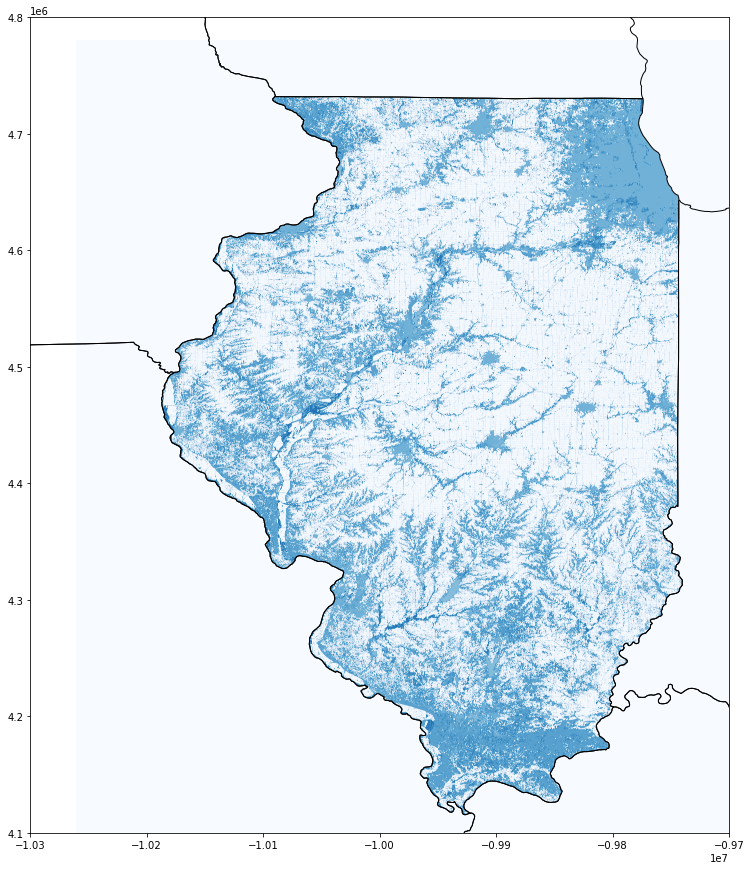

In [35]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(IL_raster16, ax=ax,cmap="Blues")
country_proj.plot(ax=ax, facecolor='none', edgecolor='black')
plt.xlim(-1.03*10**7,-.97*10**7)
plt.ylim(4.1*10**6,4.8*10**6)

Now for 2017 clip:

In [32]:
raster_file17 = "Homework_2/CDL_2017_clip.tif"

raster17 = rasterio.open(raster_file17)

In [36]:
raster17.transform

Affine(30.0, 0.0, 337545.0,
       0.0, -30.0, 2223945.0)

In [37]:
src_file17 = raster_file17
dst_file17 = 'ppt_reproj2.tif'
dst_crs17 = rasterio.crs.CRS.from_dict({'init': 'EPSG:4087'})

In [38]:
with rasterio.open(src_file17) as src: 
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs17, src.width, src.height, *src.bounds) 
    kwargs = src.meta.copy() 
    kwargs.update({
        'crs': dst_crs17,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open(dst_file17, 'w', **kwargs) as dst: 
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs17,
                resampling=Resampling.nearest)

In [39]:
raster17 = rasterio.open("./ppt_reproj2.tif")

raster17.crs

CRS.from_epsg(4087)

In [40]:
img_out2, img_transform2 = mask(raster17,IL_coords)

In [41]:
out_meta2 = raster17.meta.copy()

out_meta2['height'] = img_out2.shape[1]
out_meta2['width'] = img_out2.shape[2]
out_meta2['transform'] = img_transform

with rasterio.open("./IL_PPT.tif", "w", **out_meta) as dest:
    dest.write(img_out)

In [42]:
IL_raster17 = rasterio.open("./IL_PPT.tif")

(4099999.9999999995, 4800000.0)

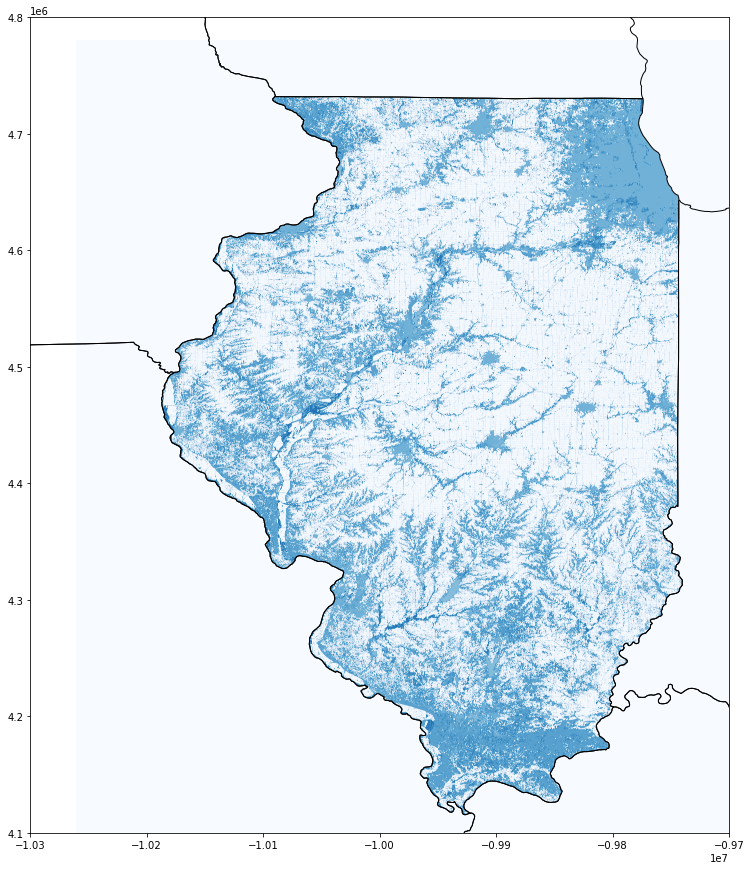

In [45]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(IL_raster17, ax=ax,cmap="Blues")
country_proj.plot(ax=ax, facecolor='none', edgecolor='black')
plt.xlim(-1.03*10**7,-.97*10**7)
plt.ylim(4.1*10**6,4.8*10**6)

Looking at dataframes of raster files

In [64]:
df17 = geopandas.read_file("Homework_2/CDL_2017_clip.tif")
df17.head()

DriverError: 'Homework_2/CDL_2017_clip.tif' not recognized as a supported file format.

## Question 2

In [61]:
import codecs
f = codecs.open('Homework_2/landuse.htm', 'r', 'utf-8')
landuse=f.read()
landuse=str(landuse)
landuse

'<!DOCTYPE html>\r\n<html lang="en">\r\n<html>\r\n<head>\r\n  <meta charset="UTF-8"/>\r\n  <meta http-equiv="X-UA-Compatible" content="IE=edge">\r\n  <meta name="viewport" content="width=device-width, initial-scale=1"/>\r\n  <title>2017 Illinois Cropland Data Layer | NASS/USDA</title>\r\n  \r\n  <meta name="dc.title" content="2017 Illinois Cropland Data Layer | NASS/USDA "/>\r\n  <meta name="dc.creator" content="United States Department of Agriculture (USDA), National Agricultural Statistics Service (NASS), Research and Development Division (RDD), Geospatial Information Branch (GIB), Spatial Analysis Research Section (SARS) "/>\r\n  <meta name="dc.subject" content="farming, 001 environment, 007 imageryBaseMapsEarthCover, 010 "/>\r\n  <meta name="dc.description" content="The USDA, NASS Cropland Data Layer (CDL) is a raster, geo-referenced, crop-specific land cover data layer. The 2017 CDL has a ground resolution of 30 meters. The CDL is produced using satellite imagery from the Landsat 